# 1. Basic graph information

## Types of graphs:
1. **Undirected:** A graph is represented by a pair $G = (V,E)$ where $V$ is the set of all vertices in the graph, and $E$ is a set of paired vertices, whose elements are called edges. A multigraph is a generalization that allows multiple edges to have the same pair of endpoints.
2. **Directed:** A directed graph (digraph) is a graph whose edges have orientations. We can write it as a pair $G = (V, E)$ where $V$ is same as above, and $E \subseteq \{(x,y) | (x, y) \in V^2 \text{ and } x \neq y \}$
3. **Node-labeled:** Given a graph $G = (V,E)$, a node-labelling is a function $\phi:V\to L$ where $L$ is a set of labels. A node-labeled graph refers to a graph with all labels distinct.
4. **Edge-labeled:** Given a graph $G = (V,E)$, an edge-labelling is a function $\varphi:E\to L$ where $L$ is a set of labels. An edge-labeled graph refers to a graph with all labels distinct.

## Representation of graphs:
1. **Adjacency matrix:** Given a finite graph $G = (V,E)$ and the vertex set $V =\{v_1, v_2, \cdots, v_n\}$, the adjacency matrix $\mathbf{A}$ is a $n\times n$ matrix such that $A_{ij} = 1$ if there is an edge from $v_i \to v_j$ else it is 0. An immediate consequence is that undirected graphs have symmetric adjacency matrices. Also, since we are avoiding self loops, which may occur in complex graphs, generally the diagonal elements of $\mathbf{A}$ are all zero.

## Node-feature representation:
Given a graph $G = (V,E)$, if for each node belonging to $V$, we have a feature vector representing the node, i.e for each node $p \in V$, we have a vector $\alpha \in \mathbb{R}^m$, we can construct the node-feature matrix $\mathbf{X} \in \mathbb{R}^{m \times |V|}$.

# 2. Problems with using previous deep learning methods to graphs

1. Graphs have different sizes. When training a feedforward neural network or a convolutional neural network, it is needed to specify an input dimension, and it is a difficult task to work with a varying dimension. Adding a single node to the graph fails the entire network.
2. If we specify the graph as it's matrix and pass it to the network, we lose node-ordering invariance. Consider two graphs $G$ and $G'$, where $G \cong G'$, i.e $G$ and $G'$ are isomorphic but with a different labelling scheme of nodes, we immediately notice that $\mathbf{A}(G) \neq \mathbf{A}(G')$. 

Thus simple deep learning methods cannot be implemented to graphs.

# 3. Computation graph
1. **Definition:** The neighbor of a node defines it's computation graph. The feature vectors of nodes A, B, E in some way define the feature vector of F and that defines of A again. The empty boxes shown are neural networks, and the combining of feature vectors should be an order invariant method, and hence we use aggregation such as sum and average.
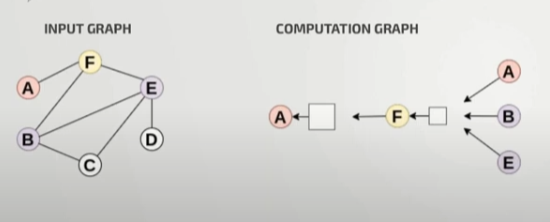
Each node in the graph has its own computation graph. This brings up a lot of redundancy in the graph. We can define the successive operations of aggregating to be unrolling the graph. The question is, how much to unroll? In 1 time step we can reach the immediate neighbors, and in 2 time steps, we can reach their neighbors too. At some time it becomes not useful to gather more information.

2. **Math:** 
    Consider $h_v^0$ as the first layer for node $v$ and that will just be the feature vector, i.e $h_v^0 = X_v$ <br>
    At the $k^{th}$ timestep, we can write $$h_v^{k+1} = \sigma\bigg(W_k \sum_{u \in \mathcal{N}(u)}\dfrac{h_u^k}{|N(v)|} + B_k h_v^k\bigg)$$
    And finally after $K$ steps, we have $Z_v = h_v^K$ where $Z_v$ is the embedding we need. <br>
    
    The equation above relates the $(k+1)^{th}$ embedding of the node to the $k^{th}$ embedding, and the average of the embedding for each neighbour of $v$. $W_k$ and $B_k$ are weights and $\sigma$ is an activation function such as ReLU. Note that $W_k$ and $B_k$ are shared parameters, and this reduces redundancy in the computation graph.
    
3. **GraphSAGE:** This is inductive representation learning on large graphs. The update rule for GraphSAGE is
    $$ h_v^{k+1} = \sigma\bigg([W_k \cdot AGG(\{h_u^{k-1}, \forall u \in \mathcal{N}(v)\}), B_kh_v^k]\bigg)$$
    The AGG above is either pooling, such as element-wise min/max and or LSTM (which breaks node-ordering). Also, we concatenate the two results instead of adding them.
    

# 4. Let's start the coding

## Loading the dataset

In [4]:
# Importing the libraries
import torch_geometric
from torch_geometric.datasets import Planetoid

In [5]:
dataset = Planetoid(root="Cora_Dataset", name="Cora")

Processing...
Done!


## Exploring the dataset

In [6]:
print(dataset)
print("Number of graphs:", len(dataset))
print("Number of classes:", dataset.num_classes)
print("Number of node_features:", dataset.num_node_features)
print("Number of edge_features:", dataset.num_edge_features)

Cora()
Number of graphs: 1
Number of classes: 7
Number of node_features: 1433
Number of edge_features: 0


In [7]:
print('Edge index:', dataset.data.edge_index.shape)
print(dataset.data.edge_index)
print()
print('Train mask:', dataset.data.train_mask.shape)
print(dataset.data.train_mask)
print()
print('X:', dataset.data.x.shape)
print(dataset.data.x)
print()
print('Y:', dataset.data.y.shape)
print(dataset.data.y)

Edge index: torch.Size([2, 10556])
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

Train mask: torch.Size([2708])
tensor([ True,  True,  True,  ..., False, False, False])

X: torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Y: torch.Size([2708])
tensor([3, 4, 4,  ..., 3, 3, 3])


## Model

In [8]:
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

In [9]:
data = dataset[0] # Since only one dataset is present

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = SAGEConv(dataset.num_features, dataset.num_classes, aggr='max') # can use max, mean, add etc. 
        # Note it is clear that since we are going from 1433 to 4 directly, the model doesn't work very well
        
    def forward(self):
        x = self.conv(data.x, data.edge_index)
        return F.log_softmax(x, dim=1)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

## Train and Test

In [14]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()

In [22]:
def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [23]:
best_val_acc = test_acc = 0
for epoch in range(1, 100):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
        
    log = "Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}"
    
    if epoch % 10 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

Epoch: 010, Val: 0.7220, Test: 0.7180
Epoch: 020, Val: 0.7220, Test: 0.7180
Epoch: 030, Val: 0.7220, Test: 0.7180
Epoch: 040, Val: 0.7220, Test: 0.7180
Epoch: 050, Val: 0.7260, Test: 0.7090
Epoch: 060, Val: 0.7300, Test: 0.7100
Epoch: 070, Val: 0.7300, Test: 0.7100
Epoch: 080, Val: 0.7300, Test: 0.7100
Epoch: 090, Val: 0.7300, Test: 0.7100
